<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_02_CoronaVirus_Conv2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 2: CoronaVirus -Conv2019 Analysis

## Libraries

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
#!pip install geopy

In [0]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve
from geopy.geocoders import Nominatim

In [0]:
import operator

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [0]:
import plotly
import plotly.express as px

In [0]:
#import os
#print(os.listdir("input"))

## Exploratory Data Analysis

### Data download

Data source: https://github.com/CSSEGISandData/COVID-19

In [0]:
githubLoc = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'

In [7]:
from datetime import date, timedelta

sdate = date(2020, 1, 22)   # start date
edate = date.today()   # end date

delta = edate - sdate       # as timedelta

appended_data = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    #print(day.strftime('%m-%d-%Y'))
    try:
      df = pd.read_csv(githubLoc + day.strftime('%m-%d-%Y')+".csv", parse_dates=True)
      appended_data.append(df)
    except:
      pass
df_corona = pd.concat(appended_data)
df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [8]:
df_corona.tail(10)

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered
239,1.0,Saint Vincent and the Grenadines,0.0,2020-03-14,12.9843,-61.2872,NaN,0.0
240,1.0,Sudan,1.0,2020-03-14,12.8628,30.2176,NaN,0.0
241,1.0,Suriname,0.0,2020-03-14,3.9193,-56.0278,NaN,0.0
242,1.0,Togo,0.0,2020-03-13,8.6195,0.8248,NaN,0.0
243,1.0,US,0.0,2020-03-12,47.5289,-99.7840,North Dakota,0.0
244,1.0,US,0.0,2020-03-14,18.3358,-64.8963,"Virgin Islands, U.S.",0.0
245,1.0,United Kingdom,0.0,2020-03-14,36.1408,-5.3536,Gibraltar,1.0
246,0.0,Australia,0.0,2020-03-14,35.4437,139.6380,From Diamond Princess,0.0
247,0.0,US,0.0,2020-03-10,38.4912,-80.9545,West Virginia,0.0
248,0.0,occupied Palestinian territory,0.0,2020-03-11,31.9522,35.2332,NaN,0.0


In [0]:
df_corona["Last Update"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona["Date"] = df_corona["Last Update"].astype('datetime64[D]')
df_corona['Country/Region'].replace({'Mainland China':'China'},inplace=True)
df_corona.fillna(value=0, inplace=True)


### Show Cases by Date

In [10]:
df_byDate = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date")
df_byDate["mort_Rate"] =(df_byDate["Deaths"]/df_byDate["Confirmed"])*100
df_byDate.tail(10)

,Confirmed,Deaths,Latitude,Longitude,Recovered,mort_Rate
Date,,,,,,
2020-03-05,97461.0,3350.0,4534.482600,2593.247800,54137.0,3.437272
2020-03-06,106265.0,3489.0,7299.946700,2246.202300,57671.0,3.283301
2020-03-07,105073.0,3553.0,5912.053400,-3203.500200,58197.0,3.381459
2020-03-08,113842.0,3881.0,7766.887000,-2424.792400,64907.0,3.409111
2020-03-09,108042.0,3920.0,3791.103700,324.888200,58658.0,3.628219
2020-03-10,114475.0,4207.0,6841.941400,-583.309600,60893.0,3.675038
2020-03-11,216385.0,7833.0,13773.123414,4946.176145,82064.0,3.619937
2020-03-12,110530.0,3798.0,4217.528300,1097.018900,67913.0,3.436171
2020-03-13,77680.0,3149.0,1584.797900,2524.694700,60254.0,4.053811


### Number of Cases in China

In [0]:
#df_corona.groupby(by="Date").sum().reset_index().sort_values(by="Date").diff()

In [12]:
nb_cases_day = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China = df_corona.loc[df_corona["Country/Region"] == "China"].groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_China.tail()

,Confirmed,Deaths,Latitude,Longitude,Recovered
Date,,,,,
2020-03-10,206.0,16.0,-10.8449,-20.9060,1525.0
2020-03-11,11289.0,156.0,1531.7155,4893.1952,12450.0
2020-03-12,-6365.0,-83.0,-1129.9728,-3384.7384,-4975.0
2020-03-13,-5565.0,-21.0,-294.2362,-1156.9242,-4202.0
2020-03-14,40.0,21.0,-185.5710,-598.5166,1450.0


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



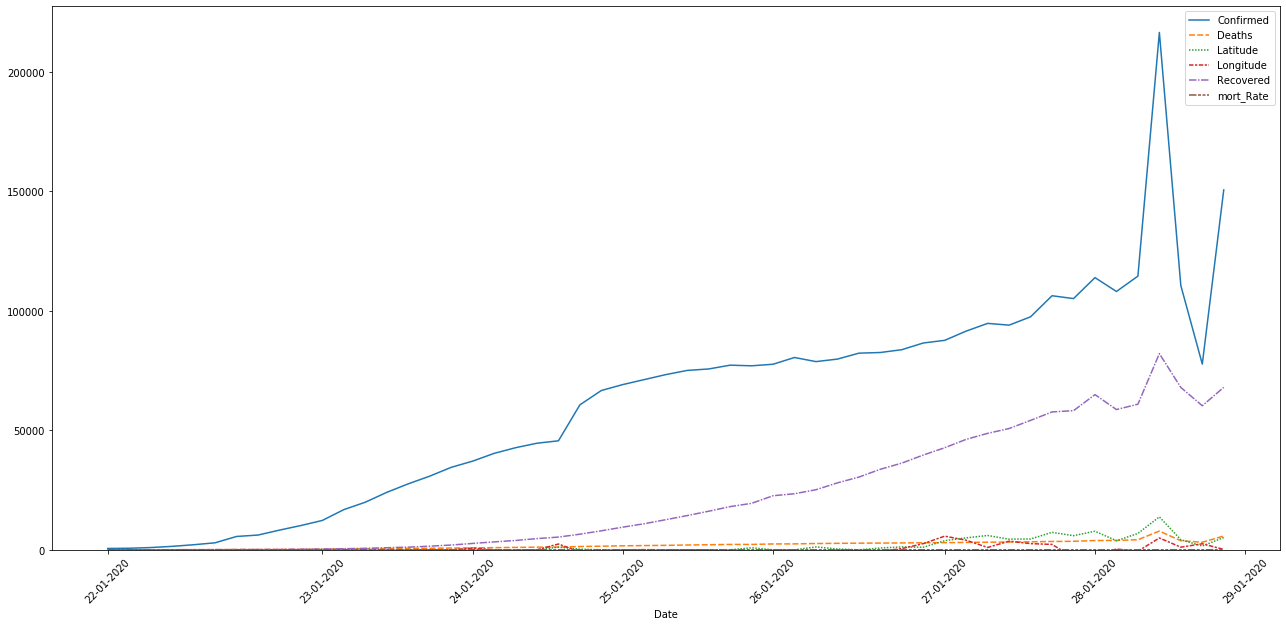

In [13]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=df_byDate)  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

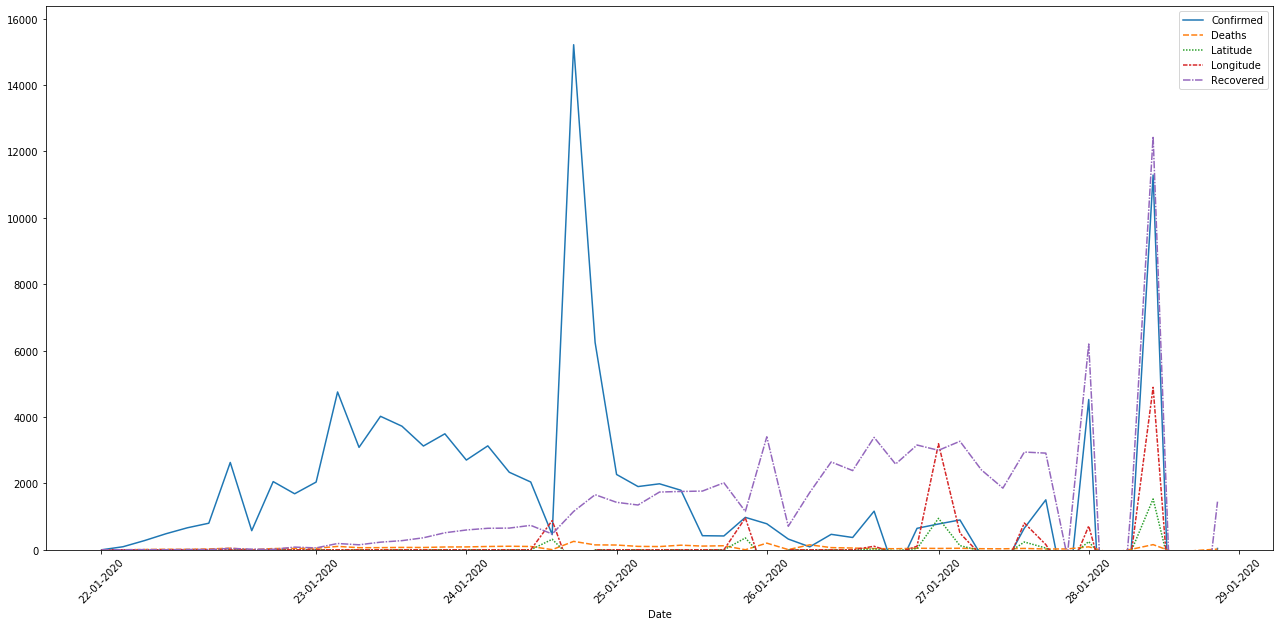

In [14]:
fig, ax = plt.subplots(figsize = (22,10))  
fig = sns.lineplot( 
    data=nb_cases_day_China)  
fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

In [15]:
nb_cases_day = df_corona.groupby(by=["Date"]).sum().reset_index().sort_values(by="Date").set_index("Date").diff().fillna(value=0)
nb_cases_day_Spain = df_corona.loc[df_corona["Country/Region"] == "Spain"]
nb_cases_day_Spain

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,Province/State,Recovered,Date
58,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
58,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
60,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
62,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
62,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
62,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
63,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
63,1.0,Spain,0.0,2020-02-01,0.0000,0.0000,0,0.0,2020-02-01
54,2.0,Spain,0.0,2020-02-09,0.0000,0.0000,0,0.0,2020-02-09
54,2.0,Spain,0.0,2020-02-09,0.0000,0.0000,0,0.0,2020-02-09


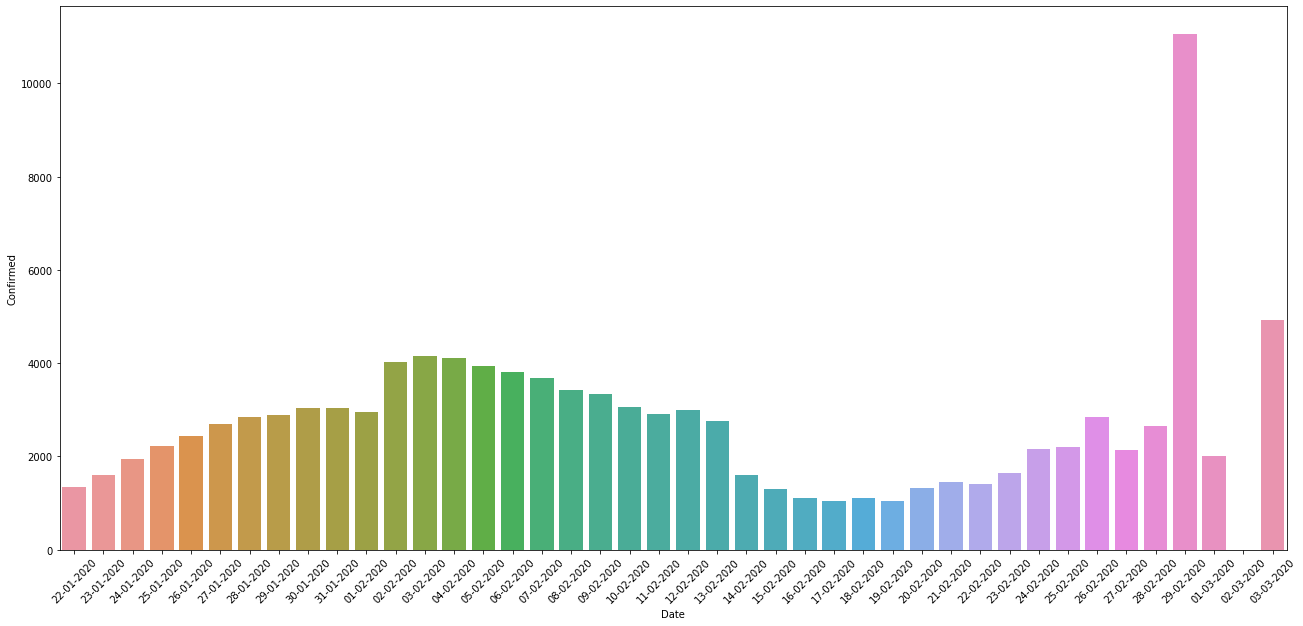

In [16]:
fig, ax = plt.subplots(figsize = (22,10))    
fig = sns.barplot(
    x = "Date", 
    y = "Confirmed", 
    data = nb_cases_day.rolling(window=12).mean().dropna().reset_index())

fig.set_xticklabels(nb_cases_day.reset_index()['Date'].dt.strftime('%d-%m-%Y'))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
fig.axis(ymin=0);

In [17]:
df_corona["Date"].max()

Timestamp('2020-03-14 00:00:00')

In [18]:
df_corona.describe()

,Confirmed,Deaths,Latitude,Longitude,Recovered
count,5632.000000,5632.000000,5632.000000,5632.000000,5632.000000
mean,582.415305,18.335760,15.558176,3.871586,213.634766
std,4935.578984,195.698066,21.457781,62.007504,2363.112194
min,0.000000,0.000000,-41.454500,-157.858400,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,0.000000,0.000000,0.000000
75%,94.000000,1.000000,36.000000,12.457800,12.000000
max,67790.000000,3075.000000,64.963100,174.886000,52960.000000


### Dataframe Info

In [19]:
df_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5632 entries, 0 to 248
Data columns (total 9 columns):
Confirmed         5632 non-null float64
Country/Region    5632 non-null object
Deaths            5632 non-null float64
Last Update       5632 non-null datetime64[ns]
Latitude          5632 non-null float64
Longitude         5632 non-null float64
Province/State    5632 non-null object
Recovered         5632 non-null float64
Date              5632 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(5), object(2)
memory usage: 440.0+ KB


In [20]:
#**Present Gobal condition: confirmed, death and recovered**
print('Data from Day: ' + str(df_corona["Date"].max().strftime('%A %m/%d/%Y')))
print('Globally Confirmed Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Confirmed'].sum())
print('Global Deaths: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Deaths'].sum())
print('Globally Recovered Cases: ',df_corona.loc[df_corona["Date"]==df_corona["Date"].max()]['Recovered'].sum())

Data from Day: Saturday 03/14/2020
Globally Confirmed Cases:  150516.0
Global Deaths:  5778.0
Globally Recovered Cases:  67946.0


In [21]:
df_corona[['Date','Country/Region','Province/State','Confirmed','Deaths','Recovered']].drop_duplicates(subset=["Date","Province/State"]).groupby(['Date','Country/Region']).sum()

Confirmed  Deaths  Recovered
Date       Country/Region                              
2020-01-22 China               547.0    17.0       28.0
           Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
...                              ...     ...        ...
2020-03-14 Denmark             836.0     1.0        1.0
           France             4480.0    91.0       12.0
           Italy             21157.0  1441.0     1966.0
           US                 2617.0    54.0       12.0
           United Kingdom     1141.0    21.0       19.0

[343 rows x 3 columns]

In [22]:
df_corona.loc[df_corona["Date"]==df_corona["Date"].max()].groupby('Country/Region')['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

,Confirmed,Deaths,Recovered
Country/Region,,,
China,76600.0,3161.0,61343.0
Italy,21157.0,1441.0,1966.0
Iran,12729.0,611.0,2959.0
"Korea, South",8086.0,72.0,510.0
Spain,6391.0,195.0,517.0
...,...,...,...
Suriname,1.0,0.0,0.0
Sudan,1.0,1.0,0.0
Guatemala,1.0,0.0,0.0


In [23]:
df_corona.loc[df_corona["Country/Region"] == "China"].groupby("Date").sum()

,Confirmed,Deaths,Latitude,Longitude,Recovered
Date,,,,,
2020-01-22,547.0,17.0,0.0000,0.0000,28.0
2020-01-23,639.0,18.0,0.0000,0.0000,30.0
2020-01-24,916.0,26.0,0.0000,0.0000,36.0
2020-01-25,1399.0,42.0,0.0000,0.0000,39.0
2020-01-26,2062.0,56.0,0.0000,0.0000,49.0
2020-01-27,2863.0,82.0,0.0000,0.0000,58.0
2020-01-28,5494.0,131.0,0.0000,0.0000,101.0
2020-01-29,6070.0,133.0,0.0000,0.0000,120.0
2020-01-30,8124.0,171.0,0.0000,0.0000,135.0


In [24]:
CasesByCountry = df_corona.groupby(by=['Country/Region','Date'])['Confirmed','Deaths','Recovered'].sum().reset_index()
CasesByCountry.loc[CasesByCountry["Date"] == CasesByCountry["Date"].max()]
CasesByCountry.loc[CasesByCountry["Date"] == '2020-02-23']

,Country/Region,Date,Confirmed,Deaths,Recovered
256,China,2020-02-23,77065.0,2445.0,23253.0
523,Hong Kong,2020-02-23,74.0,2.0,11.0
589,Iran,2020-02-23,43.0,8.0,0.0
609,Iraq,2020-02-23,0.0,0.0,0.0
656,Italy,2020-02-23,155.0,3.0,2.0
707,Japan,2020-02-23,147.0,1.0,22.0
964,Others,2020-02-23,2073.0,9.0,0.0
1132,Singapore,2020-02-23,178.0,0.0,102.0
1193,South Korea,2020-02-23,602.0,6.0,18.0
1298,Taiwan,2020-02-23,28.0,1.0,2.0


In [25]:
pivotTableCorna = pd.pivot_table(df_corona,index="Country/Region", columns="Date", values="Confirmed" ,fill_value=0,aggfunc='sum').reset_index()
pivotTableCorna

Date,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00
0,Azerbaijan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,8,0,5,21,0,0,11
2,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,45,23,0,38
3,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,3,5,24,0,34,0,19,60,0,26,24,0,37
4,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Vatican City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0
166,Venezuela,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
167,Viet Nam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0
168,Vietnam,0,2,2,2,2,2,2,2,2,2,12,0,24,0,0,20,0,26,0,14,30,0,128,0,0,0,0,0,0,0,64,0,0,0,176,0,0,0,0,0,0,0,0,0,0,18,60,0,0,85,39,0,53


In [0]:
#f, ax = plt.subplots(figsize=(17, 15))
#ax = sns.heatmap(pivotTableCorna)

In [27]:
CasesByCountry.tail()

,Country/Region,Date,Confirmed,Deaths,Recovered
1463,Vietnam,2020-03-11,85.0,0.0,32.0
1464,Vietnam,2020-03-12,39.0,0.0,16.0
1465,Vietnam,2020-03-14,53.0,0.0,16.0
1466,occupied Palestinian territory,2020-03-10,25.0,0.0,0.0
1467,occupied Palestinian territory,2020-03-11,0.0,0.0,0.0


In [28]:
CasesByCountry["Date"].max()

Timestamp('2020-03-14 00:00:00')

In [29]:
df_corona.loc[
              df_corona["Date"]==df_corona["Date"].max()].groupby(
                  ['Province/State'])['Confirmed','Deaths','Recovered'].sum().sort_values(
                      by="Confirmed", ascending=False).head(10)

,Confirmed,Deaths,Recovered
Province/State,,,
Hubei,67790.0,3075.0,52960.0
0,64414.0,2446.0,6528.0
France,4469.0,91.0,12.0
Guangdong,1356.0,8.0,1299.0
Henan,1273.0,22.0,1250.0
Zhejiang,1227.0,1.0,1211.0
United Kingdom,1140.0,21.0,18.0
Hunan,1018.0,4.0,1014.0
Denmark,827.0,1.0,1.0


In [0]:
df_corona2 = df_corona.groupby(['Date','Country/Region'])['Confirmed','Deaths','Recovered'].sum().sort_values(by="Confirmed", ascending=False)

In [0]:
df_corona2.reset_index(inplace=True)

In [32]:
fig = px.bar(
    df_corona2[['Date','Confirmed','Deaths', 'Recovered','Country/Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country/Region', 'Deaths', 'Recovered'], 
    color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [0]:
df_corona3 =df_corona2.loc[df_corona2["Country/Region"] !="China"]

In [34]:
fig = px.bar(
    df_corona3[['Date','Confirmed','Deaths', 'Recovered','Country/Region']], 
    x='Date', 
    y='Confirmed', 
    hover_data=['Country/Region', 'Deaths', 'Recovered'], 
    color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for each country',
                              font=dict(family='Arial',
                                        size=10,
                                        color='rgb(56,37,47)'),
                              showarrow=False)
                              )
fig.update_layout(annotations=annotations)
fig.show()

In [35]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'China'], x='Date', y='Confirmed', hover_data=['Province/State', 'Deaths', 'Recovered'], color='Province/State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [36]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'Singapore'].drop_duplicates(subset="Date"), 
             x='Date', y='Confirmed', 
             hover_data=['Deaths', 'Recovered'])
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Confirmed bar plot for Singapore',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [37]:
fig = px.bar(df_corona, x='Date', y='Deaths', hover_data=['Province/State', 'Confirmed', 'Recovered'], color='Country/Region')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for each country',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [38]:
fig = px.bar(df_corona.loc[df_corona['Country/Region'] == 'China'], x='Date', y='Deaths', hover_data=['Province/State', 'Confirmed', 'Recovered'], color='Province/State')
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Death bar plot for Mainland China',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

## Predicting Using Facebook Prophet vs Sklearn

In [0]:
from fbprophet.plot import plot_plotly
from fbprophet import Prophet

In [0]:
confirmed_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#confirmed_training_dataset

In [41]:
# Making the Model
prophet = Prophet()
prophet.fit(confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=37)
confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
fig = plot_plotly(prophet, confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
death_training_dataset = pd.DataFrame(df_corona.groupby('Date')['Deaths'].sum().reset_index()).rename(columns={'Date': 'ds', 'Deaths': 'y'})
#death_training_dataset

In [44]:
# Making the Model
prophet = Prophet()
prophet.fit(death_training_dataset)
future = prophet.make_future_dataframe(periods=30)
deaths_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
fig = plot_plotly(prophet, deaths_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions of Deaths',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

In [0]:
sg_confirmed_training_dataset = pd.DataFrame(df_corona.loc[df_corona['Country/Region'] == 'Singapore'].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#sg_confirmed_training_dataset

In [47]:
# Making the Model
prophet = Prophet()
prophet.fit(sg_confirmed_training_dataset)
future = prophet.make_future_dataframe(periods=30)
sg_confirmed_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
fig = plot_plotly(prophet, sg_confirmed_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

### Number of cases per day

### Prediction Singapore Cases Per Day

In [0]:
df_corona_cases_day_sg =df_corona.loc[df_corona["Country/Region"] == "Singapore"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

In [0]:
SG_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_sg.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#SG_CasesPerDay_training_dataset

In [51]:
# Making the Model
prophet = Prophet()
prophet.fit(SG_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
SG_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
fig = plot_plotly(prophet, SG_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Singapore Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

3.267452398968898
0.6983533658265109


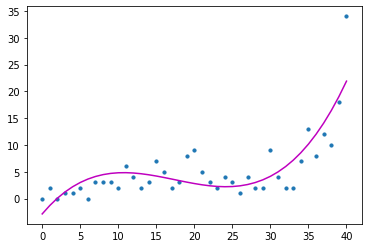

In [53]:
x = np.arange(0, SG_CasesPerDay_training_dataset.shape[0], dtype=int)
y = SG_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### China Prediction Cases Per Day

In [0]:
df_corona_cases_day_cn = df_corona.loc[df_corona["Country/Region"] == "China"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()

In [0]:
CN_CasesPerDay_training_dataset = pd.DataFrame(df_corona_cases_day_cn.groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})
#CN_CasesPerDay_training_dataset

In [56]:
# Making the Model
prophet = Prophet()
prophet.fit(CN_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=30)
CN_CasesPerDay_forecast = prophet.predict(future)
#CN_CasesPerDay_forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
fig = plot_plotly(prophet, CN_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='China Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

2039.123553327197
0.18739323313751788


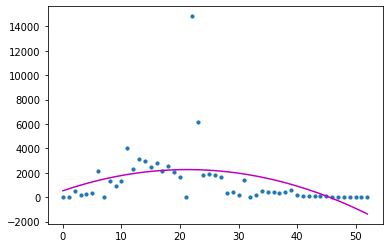

In [58]:
x = np.arange(0, CN_CasesPerDay_training_dataset.shape[0], dtype=int)
y = CN_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Prediction Spain Confirmed

In [0]:

df_corona_cases_day_spain =df_corona.loc[df_corona["Country/Region"] == "Spain"].drop_duplicates(subset="Date").groupby(by=["Country/Region","Date"]).sum().diff()
#df_corona.loc[df_corona["Country/Region"] == "Singapore"].groupby(by=["Country/Region","Date"]).sum()

In [60]:
df_corona_cases_day_spain

Confirmed  Deaths  Latitude  Longitude  Recovered
Country/Region Date                                                         
Spain          2020-02-01        NaN     NaN       NaN        NaN        NaN
               2020-02-09        1.0     0.0    0.0000     0.0000        0.0
               2020-02-15        0.0     0.0    0.0000     0.0000        2.0
               2020-02-25        4.0     0.0    0.0000     0.0000        0.0
               2020-02-26        7.0     0.0    0.0000     0.0000        0.0
               2020-02-27        2.0     0.0    0.0000     0.0000        0.0
               2020-02-28       17.0     0.0    0.0000     0.0000        0.0
               2020-02-29       13.0     0.0    0.0000     0.0000        0.0
               2020-03-01       39.0     0.0   40.0000    -4.0000        0.0
               2020-03-02       36.0     0.0    0.0000     0.0000        0.0
               2020-03-03       45.0     1.0    0.0000     0.0000        0.0
               2020-03-04       57.0     1.0    0.0000     0.0000        0.0
               2020-03-05       37.0     1.0    0.0000     0.0000        0.0
               2020-03-06      141.0     2.0    0.0000     0.0000        0.0
               2020-03-07      100.0     5.0    0.0000     0.0000       28.0
               2020-03-08      173.0     7.0    0.0000     0.0000        0.0
               2020-03-09      400.0    11.0    0.0000     0.0000        2.0
               2020-03-10      622.0     7.0    0.0000     0.0000        0.0
               2020-03-11      582.0    19.0    0.0000     0.0000      151.0
               2020-03-12        0.0     1.0    0.0000     0.0000        0.0
               2020-03-14     4114.0   140.0    0.4637     0.2508      334.0

In [0]:
Spain_CasesPerDay_training_dataset = pd.DataFrame(df_corona.loc[
                                                                (df_corona["Country/Region"] == "Spain")&(df_corona["Date"] > "20200215")].drop_duplicates(subset="Date").groupby('Date')['Confirmed'].sum().reset_index()).rename(columns={'Date': 'ds', 'Confirmed': 'y'})

In [62]:
# Making the Model
prophet = Prophet()
prophet.fit(Spain_CasesPerDay_training_dataset)
future = prophet.make_future_dataframe(periods=120)
Spain_CasesPerDay_forecast = prophet.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.


In [63]:
fig = plot_plotly(prophet, Spain_CasesPerDay_forecast)  
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Spain Cases Per Day Predictions for Confirmed',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)
fig

494.1564581866788
0.8943543788023686


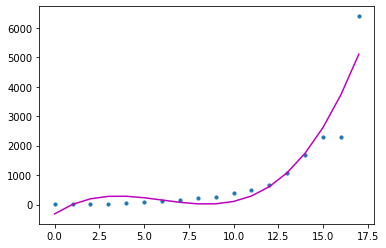

In [64]:
x = np.arange(0, Spain_CasesPerDay_training_dataset.shape[0], dtype=int)
y = Spain_CasesPerDay_training_dataset[["y"]].values
# transforming the data to include another axis
x = x[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Calculate Mortality Rate
By Country/Date

In [65]:
df_corona.groupby("Date").sum()

,Confirmed,Deaths,Latitude,Longitude,Recovered
Date,,,,,
2020-01-22,555.0,17.0,0.000000,0.000000,28.0
2020-01-23,653.0,18.0,0.000000,0.000000,30.0
2020-01-24,941.0,26.0,0.000000,0.000000,36.0
2020-01-25,1438.0,42.0,0.000000,0.000000,39.0
2020-01-26,2118.0,56.0,0.000000,0.000000,52.0
2020-01-27,2927.0,82.0,0.000000,0.000000,61.0
2020-01-28,5578.0,131.0,0.000000,0.000000,107.0
2020-01-29,6165.0,133.0,0.000000,0.000000,126.0
2020-01-30,8235.0,171.0,0.000000,0.000000,143.0


In [66]:
df_corona_MortRate = df_corona.groupby(by=["Date"]).sum().reset_index()
df_corona_MortRate

,Date,Confirmed,Deaths,Latitude,Longitude,Recovered
0,2020-01-22,555.0,17.0,0.000000,0.000000,28.0
1,2020-01-23,653.0,18.0,0.000000,0.000000,30.0
2,2020-01-24,941.0,26.0,0.000000,0.000000,36.0
3,2020-01-25,1438.0,42.0,0.000000,0.000000,39.0
4,2020-01-26,2118.0,56.0,0.000000,0.000000,52.0
5,2020-01-27,2927.0,82.0,0.000000,0.000000,61.0
6,2020-01-28,5578.0,131.0,0.000000,0.000000,107.0
7,2020-01-29,6165.0,133.0,0.000000,0.000000,126.0
8,2020-01-30,8235.0,171.0,0.000000,0.000000,143.0
9,2020-01-31,10151.0,213.0,0.000000,0.000000,239.0


In [0]:
df_corona_MortRate["MortalityRate"] = df_corona_MortRate["Deaths"]/df_corona_MortRate["Confirmed"]
df_corona_MortRate["MortalityRate"].replace([np.inf, -np.inf], np.nan)
df_corona_MortRate["MortalityRate"].fillna(value=0, inplace=True)


In [0]:
#df_corona_MortRate["MortalityRate"].loc[(~np.isfinite(df_corona_MortRate["MortalityRate"])) & df_corona_MortRate["MortalityRate"].notnull()] = 0

In [69]:
df_corona_MortRate.sort_values(by="Date", ascending=False)

,Date,Confirmed,Deaths,Latitude,Longitude,Recovered,MortalityRate
52,2020-03-14,150516.0,5778.0,5148.911700,163.579500,67946.0,0.038388
51,2020-03-13,77680.0,3149.0,1584.797900,2524.694700,60254.0,0.040538
50,2020-03-12,110530.0,3798.0,4217.528300,1097.018900,67913.0,0.034362
49,2020-03-11,216385.0,7833.0,13773.123414,4946.176145,82064.0,0.036199
48,2020-03-10,114475.0,4207.0,6841.941400,-583.309600,60893.0,0.036750
47,2020-03-09,108042.0,3920.0,3791.103700,324.888200,58658.0,0.036282
46,2020-03-08,113842.0,3881.0,7766.887000,-2424.792400,64907.0,0.034091
45,2020-03-07,105073.0,3553.0,5912.053400,-3203.500200,58197.0,0.033815
44,2020-03-06,106265.0,3489.0,7299.946700,2246.202300,57671.0,0.032833
43,2020-03-05,97461.0,3350.0,4534.482600,2593.247800,54137.0,0.034373


### Geolocation 1

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "bghai19" # username from the json file
os.environ['KAGGLE_KEY'] = "4947c3935b9ad98eacd876741ff7c11c" # key from the json file

In [71]:
!kaggle datasets download -d parulpandey/world-coordinates

  0% 0.00/5.13k [00:00<?, ?B/s]
100% 5.13k/5.13k [00:00<00:00, 4.48MB/s]


In [0]:
import zipfile

In [0]:
with zipfile.ZipFile("/content/world-coordinates.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [74]:
# Importing the world_coordinates dataset
world_coordinates = pd.read_csv('/content/input/world_coordinates.csv')
world_coordinates.tail()


,Code,Country,latitude,longitude
239,YE,Yemen,15.552727,48.516388
240,YT,Mayotte,-12.827500,45.166244
241,ZA,South Africa,-30.559482,22.937506
242,ZM,Zambia,-13.133897,27.849332
243,ZW,Zimbabwe,-19.015438,29.154857


In [75]:
# Merging the coordinates dataframe with original dataframe
df_corona_world = pd.merge(world_coordinates,df_corona,left_on='Country',right_on='Country/Region')
df_corona_world = df_corona_world.loc[df_corona_world["Date"] == df_corona_world["Date"].max()]
df_corona_world= df_corona_world.groupby(by=["Date","Country/Region","latitude","longitude"]).sum().reset_index()
df_corona_world

,Date,Country/Region,latitude,longitude,Confirmed,Deaths,Latitude,Longitude,Recovered
0,2020-03-14,Afghanistan,33.939110,67.709953,11.0,0.0,33.9391,67.7100,0.0
1,2020-03-14,Albania,41.153332,20.168331,38.0,1.0,41.1533,20.1683,0.0
2,2020-03-14,Algeria,28.033886,1.659626,37.0,3.0,28.0339,1.6596,12.0
3,2020-03-14,Argentina,-38.416097,-63.616672,34.0,2.0,-38.4161,-63.6167,1.0
4,2020-03-14,Armenia,40.069099,45.038189,18.0,0.0,40.0691,45.0382,0.0
...,...,...,...,...,...,...,...,...,...
95,2020-03-14,Tunisia,33.886917,9.537499,18.0,0.0,33.8869,9.5375,0.0
96,2020-03-14,US,37.090240,-95.712891,2617.0,54.0,1782.8060,-4303.8557,12.0
97,2020-03-14,Uruguay,-32.522779,-55.765835,4.0,0.0,-32.5228,-55.7658,0.0
98,2020-03-14,Venezuela,6.423750,-66.589730,2.0,0.0,6.4238,-66.5897,0.0


In [0]:
#df_corona_world.info()

In [0]:
import plotly.express as px
import plotly.graph_objects as go

In [78]:
fig = go.Figure(data=go.Scattergeo(
        #locationmode = 'iso_alpha',
        lon = df_corona_world['longitude'],
        lat = df_corona_world['latitude'],
        text = df_corona_world['Country/Region'] + " " + df_corona_world['Confirmed'].astype(str) + ' Confirmed Cases',
        mode = 'markers',
        marker = dict(
            size = 12,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = df_corona_world['Confirmed'],
            cmax = df_corona_world['Confirmed'].max(),
            colorbar_title="Cases by" + str(df_corona_world['Date'].max())
        )))

fig.update_layout(
        title = 'Corona Virus by Country)',
        geo = dict(
            scope='world',
            #projection_type='natural earth',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )
fig.show()

In [79]:

scl = [0,"#000000"],[0.5,"rgb(255, 0, 0)"],[1,"rgb(150, 204, 0)"]

fig = go.Figure(data=go.Scattergeo(
    lon = df_corona_world['longitude'],
    lat = df_corona_world['latitude'], 
    text = df_corona_world['Country/Region'] + " " +df_corona_world['Confirmed'].astype(str),
    marker = dict(
        color = df_corona_world['Confirmed'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = (df_corona_world['Confirmed']/2000)+10
    )
))

fig.update_layout(
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(242, 242, 242)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,


    ),
    title='CoronaViruse cases ' + df_corona_world['Date'].max().strftime('%A %m/%d/%Y'),
)
fig.show()

### Geolocation2

In [0]:
import folium 
from folium import plugins

In [81]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3)

for lat, lon, value, name, deaths in zip(df_corona_world['latitude'], df_corona_world['longitude'], df_corona_world['Confirmed'], df_corona_world['Country/Region'], df_corona_world['Deaths']):
    folium.CircleMarker([lat, lon],
                        radius=1+(deaths/100),
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map